# Data Science Intern @Lets Grow More - october - author: pragati gupta

# Task 8: Next word Prediction

In [1]:
import numpy as np
import pickle
import heapq
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [2]:
text = open('sample.txt',encoding='UTF-8').read().lower()
tr = RegexpTokenizer(r'\w+')
words = tr.tokenize(text)
unique_words = np.unique(words)
uw_index = dict((c, i) for i, c in enumerate(unique_words))

In [3]:
len_w = 5
prev = []
nextw = []
for i in range(len(words) - len_w):
    prev.append(words[i:i + len_w])
    nextw.append(words[i + len_w])
print(prev[0],nextw[0])

['project', 'gutenberg', 's', 'the', 'adventures'] of


In [4]:
X = np.zeros((len(prev), len_w, len(unique_words)), dtype=bool)
Y = np.zeros((len(nextw), len(unique_words)), dtype=bool)

In [5]:
for i, each_words in enumerate(prev):
    for j, each_word in enumerate(each_words):
        X[i, j, uw_index[each_word]] = 1
    Y[i, uw_index[nextw[i]]] = 1

In [6]:
print(X[0][1])

[False False False ... False False False]


In [7]:
model = Sequential()
model.add(LSTM(128, input_shape=(len_w, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=5, shuffle=True).history

D:\ANACONDA\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/5
811/811 [==============================] - 313s 378ms/step - loss: 5.9965 - accuracy: 0.1079 - val_loss: 7.0406 - val_accuracy: 0.0992
Epoch 2/5
811/811 [==============================] - 276s 340ms/step - loss: 5.7754 - accuracy: 0.1481 - val_loss: 7.9673 - val_accuracy: 0.1077
Epoch 3/5
811/811 [==============================] - 4368s 5s/step - loss: 5.7611 - accuracy: 0.1758 - val_loss: 8.3555 - val_accuracy: 0.1098
Epoch 4/5
811/811 [==============================] - 142s 175ms/step - loss: 5.4316 - accuracy: 0.2102 - val_loss: 8.3145 - val_accuracy: 0.1060
Epoch 5/5
811/811 [==============================] - 133s 165ms/step - loss: 5.1245 - accuracy: 0.2488 - val_loss: 8.5043 - val_accuracy: 0.0974


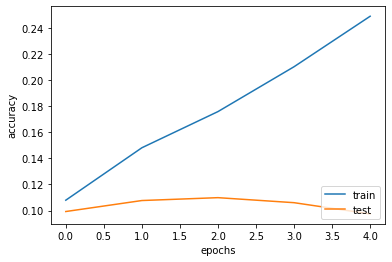

In [8]:
model.save('word-pred-model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('word-pred-model.h5')
history = pickle.load(open("history.p", "rb"))

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')

In [12]:
def prepare_input(text):
    x = np.zeros((1, len_w, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, uw_index[word]] = 1
    return x

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion
        
def predict_word(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [13]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

for q in quotes:
    print("original sentence: ",q)
    seq = " ".join(tr.tokenize(q.lower())[0:5])
    print("sequence: ",seq)
    print("next possible words: ", predict_word(seq, 5))

original sentence:  It is not a lack of love, but a lack of friendship that makes unhappy marriages.
sequence:  it is not a lack
it
is
not
a
lack
next possible words:  ['of', 's', 'when', 'the', 'should']
original sentence:  That which does not kill us makes us stronger.
sequence:  that which does not kill
that
which
does
not
kill
next possible words:  ['it', 'him', 'have', 'the', 'when']
original sentence:  I'm not upset that you lied to me, I'm upset that from now on I can't believe you.
sequence:  i m not upset that
i
m
not
upset
that
next possible words:  ['you', 'she', 'i', 'the', 'is']
original sentence:  And those who were seen dancing were thought to be insane by those who could not hear the music.
sequence:  and those who were seen
and
those
who
were
seen
next possible words:  ['there', 'in', 'of', 'and', 'with']
original sentence:  It is hard enough to remember my opinions, without also remembering my reasons for them!
sequence:  it is hard enough to
it
is
hard
enough
to
next